### Data Transformation

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from collections import Counter

# Transformations for test and validation data with augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),              # Resize all images to 224x224
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),          # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),            # Randomly flip the image vertically
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),  # Random color jitter
    transforms.ToTensor(),                      # Convert the image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])

# Define transformation (resize and convert to tensor)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor()    ,       # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])



### Setting up dataloaders


#### Creating Dataset with updated transformation


In [7]:
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import os
data_dir = "/kaggle/input/tumor-trace"
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=train_transform)
val_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=test_transform)
test_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=test_transform)

#### Creating DataLoader

In [8]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, drop_last=True)

# Check the size of each dataset
print(f'Training set size: {len(train_loader.dataset)}')
print(f'Validation set size: {len(val_loader.dataset)}')
print(f'Test set size: {len(test_loader.dataset)}')


Training set size: 20434
Validation set size: 1989
Test set size: 6851


Number of benign images: 5559
Number of malignant images: 14875


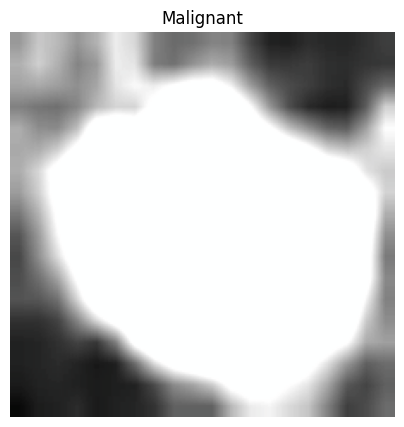

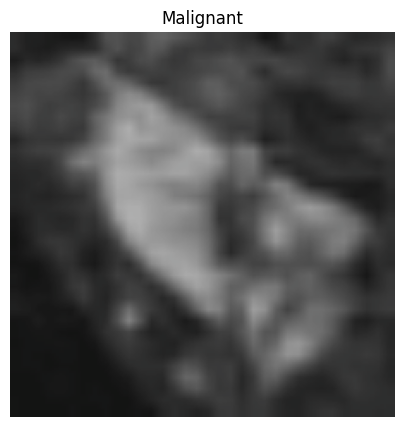

In [9]:
data_dir = "/kaggle/input/tumor-trace"
train_dataset = datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, drop_last=True)

# Count number of images in each class in the train  dataset
class_counts = Counter([label for _, label in train_dataset])
print(f"Number of benign images: {class_counts[0]}")
print(f"Number of malignant images: {class_counts[1]}")

# Display two images from the train dataset
labels_map = {0: "Benign", 1: "Malignant"}  # Mapping for labels
images_shown = 0  # Counter to show 2 images

for images, labels in train_loader:
    for i in range(2):  # Display 2 images
        img = images[i].permute(1, 2, 0).numpy()  # Convert tensor to numpy for displaying
        img = img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Unnormalize the image for visualization
        img = img.clip(0, 1)  # Clip values to be between 0 and 1

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f'{labels_map[labels[i].item()]}')  # Display 'Benign' or 'Malignant'
        plt.axis('off')
        plt.show()

        images_shown += 1
        if images_shown >= 2:
            break
    if images_shown >= 2:
        break

# **Anaylzing the dataset**

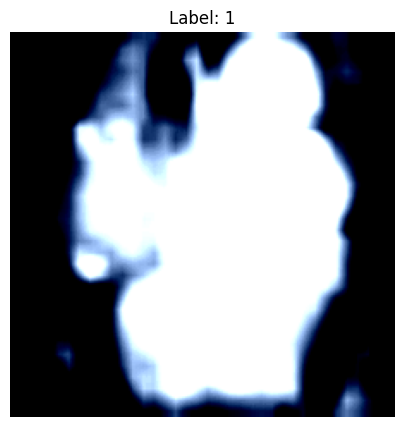

In [10]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Define transformation (resize and convert to tensor)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize all images to 224x224
    transforms.ToTensor()           # Convert images to PyTorch tensors
])

# Iterate over a batch of images
for images, labels in train_loader:
    # Convert tensor to numpy for displaying
    img = images[0].permute(1, 2, 0).numpy()  # Change dimensions for plotting
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(f'Label: {labels[0].item()}')
    plt.axis('off')
    plt.show()
    break  # Display only one image


In [11]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from skimage import exposure

# Display two images with HOG, Edge Detection, and Corner Detection
images_shown = 0  # Counter to limit to two images

for images, labels in train_loader:
    img = images[0].permute(1, 2, 0).numpy()  # Convert tensor to numpy (H, W, C)

    # Convert to grayscale and scale between 0 and 255
    img = (img * 255).astype(np.uint8).squeeze()

    ### 1. HOG (Histogram of Oriented Gradients) ###
    hog_features, hog_image = hog(img, pixels_per_cell=(16, 16), cells_per_block=(2, 2), 
                                  visualize=True, feature_vector=False, block_norm='L2-Hys')
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    ### 2. Edge Detection (Canny) ###
    edges = cv2.Canny(img, threshold1=100, threshold2=200)

    ### 3. Corner Detection (Harris Corner Detection) ###
    corners = cv2.cornerHarris(img, blockSize=2, ksize=3, k=0.04)
    corners = cv2.dilate(corners, None)  # Dilate to mark corners
    img_corners = img.copy()
    img_corners[corners > 0.01 * corners.max()] = 255

    ### Display Results ###
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 4, 1)
    plt.imshow(img, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # HOG Features
    plt.subplot(1, 4, 2)
    plt.imshow(hog_image_rescaled, cmap='gray')
    plt.title('HOG Features')
    plt.axis('off')

    # Edge Detection
    plt.subplot(1, 4, 3)
    plt.imshow(edges, cmap='gray')
    plt.title('Edge Detection')
    plt.axis('off')

    # Corner Detection
    plt.subplot(1, 4, 4)
    plt.imshow(img_corners, cmap='gray')
    plt.title('Corner Detection')
    plt.axis('off')

    plt.show()

    images_shown += 1
    if images_shown >= 2:  # Stop after displaying 2 images
        break


ValueError: Only images with two spatial dimensions are supported. If using with color/multichannel images, specify `channel_axis`.

# **Sobel Edge Detection**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Function to perform convolution
def convolve(image, kernel):
    image_x, image_y = image.shape  # dimensions (height and width) of the image
    kernel_x, kernel_y = kernel.shape  # dimensions of the kernel

    # Determining the output dimensions
    stride = 1  # step size by which we move the kernel across the image
    padding = 0  # no padding for simplicity

    output_x = int(((image_x - kernel_x + 2 * padding) / stride) + 1)  # dimensions of the output image
    output_y = int(((image_y - kernel_y + 2 * padding) / stride) + 1)

    # Initialize the output feature map
    output = np.zeros((output_x, output_y))  # matrix initialized to zeros to store the convolution result

    # Perform convolution
    for i in range(output_x):
        for j in range(output_y):
            region = image[i:i + kernel_x, j:j + kernel_y]  # extract the region of the image
            output[i, j] = np.sum(region * kernel)  # element-wise multiplication and sum

    return output

# Sobel x operator (horizontal edges)
sobel_x = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]
])

# Sobel y operator (vertical edges)
sobel_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

# Load the image and convert it to grayscale
image_path = r'/kaggle/input/tumor-trace/test/Benign/BreaDM-Be-1822/SUB3p-030.jpg'  # Ensure you provide the correct path to your image
image = Image.open(image_path).convert('L')  # Convert to grayscale
resized_image = image.resize((256, 256))  # Resize the image

# Convert the resized image to a NumPy array
image = np.array(resized_image)

# Apply Sobel x operator
sobel_x_image = convolve(image, sobel_x)

# Apply Sobel y operator
sobel_y_image = convolve(image, sobel_y)

# Calculate the magnitude of gradients
sobel_combined = np.sqrt(sobel_x_image**2 + sobel_y_image**2)

# Plot the results
plt.figure(figsize=(10, 10))

plt.subplot(1, 3, 1)
plt.imshow(sobel_x_image, cmap='gray')
plt.title('Sobel X (Horizontal Edges)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sobel_y_image, cmap='gray')
plt.title('Sobel Y (Vertical Edges)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(sobel_combined, cmap='gray')
plt.title('Sobel Combined Edge Detection')
plt.axis('off')

plt.show()


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_lbp(image):
    height, width = image.shape
    lbp_image = np.zeros((height, width), dtype=np.uint8)

    # Iterate over the image excluding border pixels
    for i in range(1, height - 1):
        for j in range(1, width - 1):
            center = image[i, j]
            neighbors = [
                image[i - 1, j - 1], image[i - 1, j], image[i - 1, j + 1],
                image[i, j + 1], image[i + 1, j + 1], image[i + 1, j],
                image[i + 1, j - 1], image[i, j - 1]
            ]

            lbp_code = 0
            for k in range(8):
                if neighbors[k] >= center:
                    lbp_code |= (1 << k)

            lbp_image[i, j] = lbp_code

    return lbp_image

# Display image inline in Kaggle
def show_image_inline(image, title="Image"):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    file_path = r'/kaggle/input/tumor-trace/test/Benign/BreaDM-Be-1822/SUB3/p-030.jpg'

    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize image to 224x224
    image = cv2.resize(image, (224, 224))

    # Calculate LBP image
    lbp_image = calculate_lbp(image)

    # Display LBP image (for Kaggle environment)
    show_image_inline(lbp_image, title="LBP Image")

    # Save LBP image
    cv2.imwrite('lbp_image.jpg', lbp_image)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_mean_median_variance(image):
    height, width = image.shape
    
    mean_image = np.zeros((height, width), dtype=np.float32)
    median_image = np.zeros((height, width), dtype=np.float32)
    variance_image = np.zeros((height, width), dtype=np.float32)

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            # Extract 3x3 neighborhood
            neighbors = [
                image[i - 1, j - 1], image[i - 1, j], image[i - 1, j + 1],
                image[i, j + 1], image[i + 1, j + 1], image[i + 1, j],
                image[i + 1, j - 1], image[i, j - 1]
            ]
            
            # Calculate mean, median, and variance
            mean_image[i, j] = np.mean(neighbors)
            median_image[i, j] = np.median(neighbors)
            variance_image[i, j] = np.var(neighbors)
    
    return mean_image, median_image, variance_image

# Display image inline in Kaggle
def show_image_inline(title, image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    # Update the file path to match your Kaggle dataset structure
    file_path = '/kaggle/input/tumor-trace/test/Benign/BreaDM-Be-1822/SUB3/p-030.jpg'

    # Read the image in grayscale
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize image to 224x224
    image = cv2.resize(image, (224, 224))

    # Calculate mean, median, and variance images
    mean_image, median_image, variance_image = calculate_mean_median_variance(image)

    # Normalize the images for better visualization
    mean_image_normalized = cv2.normalize(mean_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    median_image_normalized = cv2.normalize(median_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    variance_image_normalized = cv2.normalize(variance_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Display the mean, median, and variance images inline
    show_image_inline('Mean Image', mean_image_normalized)
    show_image_inline('Median Image', median_image_normalized)
    show_image_inline('Variance Image', variance_image_normalized)

    # Save the mean, median, and variance images
    cv2.imwrite('mean_image.jpg', mean_image_normalized)
    cv2.imwrite('median_image.jpg', median_image_normalized)
    cv2.imwrite('variance_image.jpg', variance_image_normalized)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_mean_lbp_image(image):
    height, width = image.shape
    lbp_image = np.zeros((height, width), dtype=np.uint8)

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            center = image[i, j]
            neighbors = [
                image[i - 1, j - 1], image[i - 1, j], image[i - 1, j + 1],
                image[i, j + 1], image[i + 1, j + 1], image[i + 1, j],
                image[i + 1, j - 1], image[i, j - 1]
            ]
            mean_val = np.mean(neighbors)
            lbp_code = 0

            for k, neighbor in enumerate(neighbors):
                if neighbor >= mean_val:
                    lbp_code |= (1 << k)
            lbp_image[i, j] = lbp_code

    return lbp_image

def show_image_inline(title, image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Main code
if __name__ == "__main__":
    # Update the file path to match your Kaggle dataset
    file_path = '/kaggle/input/tumor-trace/test/Benign/BreaDM-Be-1822/SUB3/p-030.jpg'

    # Load the image in grayscale
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"File not found: {file_path}")

    # Resize the image to 224x224
    image = cv2.resize(image, (224, 224))

    # Calculate the mean-based LBP image
    lbp_image = calculate_mean_lbp_image(image)

    # Display the LBP image inline
    show_image_inline("Mean LBP Image", lbp_image)

    # Save the LBP image
    cv2.imwrite('mean_lbp_image.jpg', lbp_image)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_median_lbp_image(image):
    height, width = image.shape
    lbp_image = np.zeros((height, width), dtype=np.uint8)

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            center = image[i, j]
            neighbors = [
                image[i - 1, j - 1], image[i - 1, j], image[i - 1, j + 1],
                image[i, j + 1], image[i + 1, j + 1], image[i + 1, j],
                image[i + 1, j - 1], image[i, j - 1]
            ]
            median_val = np.median(neighbors)
            lbp_code = 0

            for k, neighbor in enumerate(neighbors):
                if neighbor >= median_val:
                    lbp_code |= (1 << k)
            lbp_image[i, j] = lbp_code

    return lbp_image

def show_image_inline(title, image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Main Code
if __name__ == "__main__":
    # Update file path to match your Kaggle dataset structure
    file_path = '/kaggle/input/tumor-trace/test/Benign/BreaDM-Be-1822/SUB3/p-030.jpg'

    # Load the image in grayscale
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"File not found: {file_path}")

    # Resize the image to 224x224
    image = cv2.resize(image, (224, 224))

    # Calculate the median-based LBP image
    lbp_image = calculate_median_lbp_image(image)

    # Display the LBP image inline
    show_image_inline("Median LBP Image", lbp_image)

    # Save the LBP image
    cv2.imwrite('median_lbp_image.jpg', lbp_image)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def calculate_variance_lbp_image(image):
    height, width = image.shape
    lbp_image = np.zeros((height, width), dtype=np.uint8)

    for i in range(1, height - 1):
        for j in range(1, width - 1):
            center = image[i, j]
            neighbors = [
                image[i - 1, j - 1], image[i - 1, j], image[i - 1, j + 1],
                image[i, j + 1], image[i + 1, j + 1], image[i + 1, j],
                image[i + 1, j - 1], image[i, j - 1]
            ]
            variance_val = np.var(neighbors)
            lbp_code = 0

            for k, neighbor in enumerate(neighbors):
                if neighbor >= variance_val:
                    lbp_code |= (1 << k)
            lbp_image[i, j] = lbp_code

    return lbp_image

def show_image_inline(title, image):
    plt.figure(figsize=(6, 6))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Main Code
if __name__ == "__main__":
    # Update the file path to match your Kaggle dataset structure
    file_path = '/kaggle/input/tumor-trace/test/Benign/BreaDM-Be-1822/SUB3/p-030.jpg'

    # Load the image in grayscale
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"File not found: {file_path}")

    # Resize the image to 224x224
    image = cv2.resize(image, (224, 224))

    # Calculate the variance-based LBP image
    lbp_image = calculate_variance_lbp_image(image)

    # Display the LBP image inline
    show_image_inline("Variance LBP Image", lbp_image)

    # Save the LBP image
    cv2.imwrite('variance_lbp_image.jpg', lbp_image)


In [ ]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def calculate_horizontal_glcm(image, num_levels=256):
    """
    Manually + for a given grayscale image.
    
    Parameters:
        image (numpy.ndarray): Grayscale input image.
        num_levels (int): Number of gray levels. Default is 256 for 8-bit images.
        
    Returns:
        glcm (numpy.ndarray): Computed GLCM with shape (num_levels, num_levels).
    """
    # Initialize the GLCM matrix with zeros; each cell represents a gray-level pair frequency
    glcm = np.zeros((num_levels, num_levels), dtype=np.int32)

    # Loop through each pixel in the image, except for the last column
    for i in range(image.shape[0]):
        for j in range(image.shape[1] - 1):
            # Current pixel gray-level intensity
            row = image[i, j]
            # Neighbor pixel's gray-level intensity (next pixel in the horizontal direction)
            col = image[i, j + 1]
            # Increment GLCM entry for the observed intensity pair
            glcm[row, col] += 1

    # Normalize the GLCM matrix by dividing each value by the sum of all values, converting it to relative frequencies
    glcm = glcm / glcm.sum()
    return glcm

def show_glcm(glcm, title):
    """
    Display GLCM as a grayscale heatmap for easy visualization of texture information.
    
    Parameters:
        glcm (numpy.ndarray): Computed GLCM matrix.
        title (str): Title of the plot for display purposes.
    """
    plt.figure(figsize=(6, 6))  # Set plot size
    plt.imshow(glcm, cmap='gray')  # Display GLCM as grayscale image
    plt.title(title)  # Add title
    plt.xlabel('Gray Level Intensity of Pixel Pairs')
    plt.ylabel('Gray Level Intensity of Pixel Pairs')
    plt.colorbar(label='Relative Frequency')  # Add color bar to show frequency scale
    plt.show()

# Set the directory where images are stored
image_dir = r'/kaggle/input/tumor-trace/test/Benign/BreaDM-Be-1822/SUB3'

# List to store paths of images found in the directory
image_paths = []

# Walk through the directory to collect paths of up to 5 images
for root, dirs, files in os.walk(image_dir):
    for file in files:
        # Check for common image file formats
        if file.endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))
        if len(image_paths) >= 5:  # Stop once we have 5 images
            break
    if len(image_paths) >= 5:
        break

# If fewer than 5 images are found, notify the user
if len(image_paths) < 5:
    print("Fewer than 5 images found in the directory.")
else:
    # Process each image path found
    for i, file_path in enumerate(image_paths):
        print(f"Processing image {i + 1}: {file_path}")

        # Load the image in grayscale
        image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Error loading image at {file_path}. Check if file exists and is an image.")
            continue

        # Resize image to a fixed size (optional, for consistent GLCM calculation)
        image = cv2.resize(image, (224, 224))

        # Calculate the horizontal GLCM (considering only horizontally adjacent pixels)
        glcm = calculate_horizontal_glcm(image)
        
        # Display the GLCM as a heatmap for visualization
        show_glcm(glcm, f"GLCM for Image {i + 1} (Horizontal Direction)")


### Setting up the VggCustomMode

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models

#Customvgg16 class inherit from nn.Module
class CustomVGG16(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomVGG16, self).__init__()

        # Loading pre-trained VGG16 model from tourchvision.models
        vgg16 = models.vgg16(pretrained=True)

        # Extracting the features and avgpool layers frm pretrainedmodel
        self.features = vgg16.features
        self.avgpool = vgg16.avgpool

        # Define a new classifier nm.Sequential
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096), #input and output
            nn.ReLU(inplace=True), #for activation
            nn.Dropout(), #for regularization
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):

        x = self.features(x) # Passing the input through the features layer
        x = self.avgpool(x) # Using the avgpool layer
        x = torch.flatten(x, 1) # Reshaping the output to a 2D tensor
        x = self.classifier(x) # Passing the reshaped output to the custom classifier
        return x

# printing model
if __name__ == "__main__":
    model = CustomVGG16(num_classes=2)
    print(model)
    

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CustomVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di

**Earlystopping**

In [3]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):

        self.patience = patience # How long to wait after last time validation loss improved.
        self.verbose = verbose #If true, prints a message for each validation loss improvement. 
        self.delta = delta # Minimum change in monotered quality to quantofy improvement
        self.path = path # file path for saving the model checkpoint
        self.trace_func = trace_func # fun to output message
        self.counter = 0 # track of epochs with no improvement.
        self.best_score = None #store the best score
        self.early_stop = False #indicating whether to stop training.
        self.val_loss_min = np.Inf # store the minimum validation loss encountered during training
        #self.best_epoch = 0 #The epoch number of the best model.
        #Epoch is used to describe one complete pass through the entire training dataset.


    def __call__(self, val_loss, model):
        # method is called at end of each epoch to check if the validation loss has improved.
        score = -val_loss

        if self.best_score is None:
            self.best_score = score #the current score is set as the best score
            self.save_checkpoint(val_loss, model)
            
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

# checkpoint methond
    def save_checkpoint(self, val_loss, model):

        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). save model')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss


**Train**

In [32]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def train(epoch, model, total_epochs, train_loader, criterion, lr_decay, lr, device_type='cuda'):
    learning_rate = max(lr * (0.1 ** (epoch // 10)), lr - 5)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=lr_decay)
    
    model.train()
    correct = 0
    
    for data, label in tqdm(loader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):
        data = data.float()
        label = label.long()
        
        if device == 'cuda':
            data, label = data.to(device), label.to(device)
        
        output = model(data)
        optimizer.zero_grad()
        loss = F.nll_loss(F.log_softmax(output, dim=1), label)
        loss.backward()
        optimizer.step()
        
        pred = output.data.max(1)[1]  # Get the index of the max log-probability
        correct += pred.eq(label.data.view_as(pred)).cpu().sum()
    
    print(f'train accuracy: {100. * correct / len(loader.dataset):.2f}%')


**Validation**

In [5]:
#Validation Function

import torch
import torch.nn.functional as F
from sklearn import metrics
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import auc as sklearn_auc
from torch.cuda.amp import GradScaler, autocast

def validation(model, val_dataloader, criterion, device):
    name = 'val'  # change name to test if using for test data
    len_val_dataloader = len(val_dataloader.dataset)
    model.eval()  # Set the model to evaluation mode
    val_loss = 0
    correct = 0
    all_predictions = []
    all_targets = []
    possibilitys = None

    with torch.no_grad():  # Ensuring no gradients are computed, saving memory and computation
        for data, target in val_dataloader:
            data, target = data.to(device), target.to(device)

            val_output = model(data)  # Getting model's predictions
            val_loss += F.nll_loss(F.log_softmax(val_output, dim=1), target, reduction='sum').item()  # Calculate the loss
            pred = val_output.data.max(1)[1]  # Get the index of the max log-probability

            all_predictions.extend(pred.cpu().numpy())  # Gets the predicted class for each input
            possibility = F.softmax(val_output, dim=1).cpu().data.numpy()  # Softmax is used to convert the range of values in an array between 0-1

            if possibilitys is None:
                possibilitys = possibility
            else:
                possibilitys = np.concatenate((possibilitys, possibility), axis=0)

            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

            all_targets.extend(target.cpu().numpy())  # Collect all target labels

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    cm = metrics.confusion_matrix(all_targets, all_predictions)
    print("Confusion Matrix:\n", cm)

    # One-hot encode the labels for AUC computation
    num_classes = val_output.shape[1]
    label_onehot = np.eye(num_classes)[all_targets.astype(int)]

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(label_onehot.ravel(), possibilitys.ravel())
    auc_score = sklearn_auc(fpr, tpr)
    
    val_loss /= len(val_dataloader.dataset)
    accuracy = 100. * correct / len(val_dataloader.dataset)

    print('Specificity: {:.4f}, Sensitivity: {:.4f}, AUC: {:.4f}'.format(1 - fpr[0], tpr[0], auc_score))
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            val_loss, correct, len(val_dataloader.dataset), accuracy))

    return accuracy, val_loss, auc_score


**Test**

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted label')
    plt.show()

def plot_auc(fpr, tpr, auc_score):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc_score:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

**test Function**

In [23]:
# Test the model
test_accuracy, test_loss, test_auc = test(model, test_loader, criterion, device)

print(f'Test set results - Accuracy: {test_accuracy:.2f}%, Loss: {test_loss:.4f}, AUC: {test_auc:.4f}')

NameError: name 'test' is not defined

In [15]:
# Check the first batch of data
for data, label in train_loader:
    print(data.shape)  # Should print a tensor shape (batch_size, channels, height, width)
    print(label)  # Should print the labels for this batch
    break


torch.Size([32, 3, 224, 224])
tensor([1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0])


In [43]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [8]:

model.to(device)  
model = CustomVGG16(num_classes=2).to(device)
criterion = torch.nn.CrossEntropyLoss()
best_accuracy = 0
total_epochs = 50
lr = 0.01
momentum = 0.9
no_cuda = False
log_interval = 10 
lr_decay = 1e-4
model_name = 'vgg16'

In [36]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

# EarlyStopping class should be defined elsewhere in the code
early_stop = EarlyStopping(patience=20, verbose=True)

project_name = 'tumor_classification'
model_name = 'vgg16'
model_save_dir = './model_checkpoints'

# Assuming total_epochs, train_loader, val_loader, criterion, lr_decay, lr are defined earlier in the code

# Main training loop
for epoch in range(1, total_epochs + 1):
    # Train the model
    train(epoch, model, total_epochs, train_loader, criterion, lr_decay, lr)

    # Validation phase
    with torch.no_grad():
        _, test_loss, auc = validation(model, val_loader, criterion, device)

    # Check if model is wrapped in DataParallel or DistributedDataParallel
    model_state_dict = model.module.state_dict() if isinstance(model, nn.parallel.DistributedDataParallel) else model.state_dict()

    # Create model save directory if it does not exist
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)

    # Early stopping based on validation loss
    early_stop(test_loss, model)

    # Save the model if it has the best performance (AUC in this case)
    if auc > best_accuracy:
        best_accuracy = auc
        torch.save(model_state_dict, os.path.join(model_save_dir, f'{model_name}_{epoch}.pth'), _use_new_zipfile_serialization=False)

    # Check for early stopping condition
    if early_stop.early_stop:
        print("Early stopping")
        break


NameError: name 'loader' is not defined

Test

In [22]:
# Test the model
test_accuracy, test_loss, test_auc = test(model, test_loader, criterion, device)

print(f'Test set results - Accuracy: {test_accuracy:.2f}%, Loss: {test_loss:.4f}, AUC: {test_auc:.4f}')

NameError: name 'test' is not defined

# **Resnet18** 

In [26]:
import torch
import torch.nn as nn
from torchvision import models

class Resnet18(nn.Module):
    def __init__(self, num_classes=2):
        super(Resnet18, self).__init__()
        
        # Load pretrained ResNet18 model
        model_resnet18 = models.resnet18(pretrained=True)
        
        # Use the existing layers from the pretrained model
        self.conv1 = model_resnet18.conv1
        self.bn1 = model_resnet18.bn1
        self.relu = model_resnet18.relu
        self.maxpool = model_resnet18.maxpool
        self.layer1 = model_resnet18.layer1
        self.layer2 = model_resnet18.layer2
        self.layer3 = model_resnet18.layer3
        self.layer4 = model_resnet18.layer4
        self.avgpool = model_resnet18.avgpool
        
        # Replace the fully connected layer to match the number of classes
        in_features = model_resnet18.fc.in_features
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten the output for the fully connected layer
        x = self.fc(x)
        return x


# **Resnet50**

In [34]:
import torch
import torch.nn as nn
from torchvision import models

class Resnet50(nn.Module):
    def __init__(self, num_classes=2):
        super(Resnet50, self).__init__()
        
        # Load pretrained ResNet50 model
        model_resnet50 = models.resnet50(pretrained=True)
        
        # Use the existing layers from the pretrained model
        self.conv1 = model_resnet50.conv1
        self.bn1 = model_resnet50.bn1
        self.relu = model_resnet50.relu
        self.maxpool = model_resnet50.maxpool
        self.layer1 = model_resnet50.layer1
        self.layer2 = model_resnet50.layer2
        self.layer3 = model_resnet50.layer3
        self.layer4 = model_resnet50.layer4
        self.avgpool = model_resnet50.avgpool
        
        # Replace the fully connected layer to match the number of classes
        in_features = model_resnet50.fc.in_features
        self.fc = nn.Linear(in_features, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  # Flatten the output for the fully connected layer
        x = self.fc(x)
        return x
